In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def parse_single_log_file(log_content):
    """
    Parses a single log file and strictly handles resume overlaps 
    by keeping only the latest entry for any given step.
    """
    resume_pattern = re.compile(r"Resumed from step (\d+)")
    train_pattern = re.compile(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*Step (\d+) \| Loss: ([-\d\.]+) \| Acc: ([-\d\.]+) \| Dist: ([-\d\.]+) \| Ent: ([-\d\.]+)")
    eval_pattern = re.compile(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*>> \[Initial EVAL\] Accuracy:\s*([-\d\.]+), format:\s*([-\d\.]+)")
    
    train_dict = {} 
    eval_list = []
    current_step = 0
    
    lines = log_content.strip().split('\n')
    for line in lines:
        if "Resumed from step" in line:
            match = resume_pattern.search(line)
            if match:
                resume_step = int(match.group(1))
                current_step = resume_step
                steps_to_remove = [k for k in train_dict if k > resume_step]
                for k in steps_to_remove: del train_dict[k]

        if "| Step" in line and "Loss:" in line:
            match = train_pattern.search(line)
            if match:
                step = int(match.group(2))
                current_step = step
                train_dict[step] = {
                    "timestamp": pd.to_datetime(match.group(1)),
                    "step": step,
                    "loss": float(match.group(3)),
                    "train_acc": float(match.group(4)),
                    "dist": float(match.group(5)),
                    "ent": float(match.group(6))
                }

        if ">> [Initial EVAL]" in line:
            match = eval_pattern.search(line)
            if match:
                eval_list.append({
                    "timestamp": pd.to_datetime(match.group(1)),
                    "step": current_step,
                    "eval_acc": float(match.group(2)),
                    "eval_format": float(match.group(3))
                })

    df_train = pd.DataFrame(train_dict.values())
    if not df_train.empty:
        df_train = df_train.sort_values("step").set_index("step")

    df_eval = pd.DataFrame(eval_list)
    if not df_eval.empty:
        df_eval = df_eval.drop_duplicates(subset='step', keep='last')
        df_eval = df_eval.sort_values("step").set_index("step")
    
    return df_train, df_eval

def get_filtered_results(root_dir=".", model_filter=None, min_steps=0):
    """
    Loads experiment data with overlap handling.
    """
    folder_regex = re.compile(
        r"config_"
        r"(?P<method>[a-z_]+)_"       
        r"beta(?P<beta>[\d\.]+)_"     
        r"target(?P<target>[\d\.]+)"  
        r"(?:_w(?P<window>\d+))?_"    
        r"(?P<model>[0-9a-zA-Z\.]+)"  
        r"_countdown"
    )

    all_experiments = []
    experiment_data = {} 

    folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f)) and f.startswith("config_")]
    print(f"Processing {len(folders)} folders...")

    for folder in folders:
        log_path = os.path.join(root_dir, folder, "training.log")
        match = folder_regex.match(folder)
        if not match: continue
            
        params = match.groupdict()
        model_size = params["model"]
        
        if model_filter:
            valid_models = [model_filter] if isinstance(model_filter, str) else model_filter
            if model_size not in valid_models: continue

        if os.path.exists(log_path):
            with open(log_path, 'r') as f:
                content = f.read()

            df_train, df_eval = parse_single_log_file(content)
            
            total_steps = df_train.index.max() if not df_train.empty else 0
            
            if total_steps < min_steps: continue

            experiment_data[folder] = {"train": df_train, "eval": df_eval}
            
            init_acc = df_eval.loc[0, "eval_acc"] if (not df_eval.empty and 0 in df_eval.index) else 0.0
            if init_acc == 0.0 and not df_eval.empty: init_acc = df_eval.iloc[0]["eval_acc"]

            exp_info = {
                "exp_id": folder,
                "method": params["method"],
                "model": model_size,
                "beta": float(params["beta"]),
                "target": float(params["target"]),
                "window": int(params["window"]) if params["window"] else float('nan'),
                "total_steps": total_steps,
                "init_acc": init_acc, 
                "max_eval_acc": df_eval["eval_acc"].max() if not df_eval.empty else 0,
                "final_train_acc": df_train["train_acc"].iloc[-1] if not df_train.empty else 0
            }
            all_experiments.append(exp_info)

    df_summary = pd.DataFrame(all_experiments)
    if not df_summary.empty:
        df_summary = df_summary.sort_values(by=["model", "method", "beta"])
        
    return df_summary, experiment_data


print("Reloading data with overlap fix...")
df_3b_stable, data_3b = get_filtered_results(
    root_dir="runs", 
    model_filter="3b", 
    min_steps=100
)

print("--- ALL RESULTS ---")
df_all, _ = get_filtered_results("runs")
display(df_all)

print("\n--- FILTERED: 3b Models, Steps > 100 ---")
df_3b_stable, data_3b = get_filtered_results(
    root_dir="runs", 
    model_filter="3b", 
    min_steps=100
)

display(
    df_3b_stable.style.bar(subset=['init_acc', 'max_eval_acc'], color='#5fba7d', vmin=0, vmax=1.0)
    .format("{:.2f}", subset=['init_acc', 'max_eval_acc', 'final_train_acc', 'beta', 'target'])
)

Reloading data with overlap fix...
Processing 14 folders...
--- ALL RESULTS ---
Processing 14 folders...


,exp_id,method,model,beta,target,window,total_steps,init_acc,max_eval_acc,final_train_acc
12,config_approx_kl_beta0.05_target0_3b_countdown,approx_kl,3b,0.05,0.00,NaN,307,0.06,0.27,0.14
1,config_approx_kl_beta0.1_target0_3b_countdown,approx_kl,3b,0.10,0.00,NaN,160,0.08,0.16,0.12
4,config_approx_kl_beta0.2_target0_3b_countdown,approx_kl,3b,0.20,0.00,NaN,163,0.08,0.17,0.11
5,config_kl_beta0.05_target0_3b_countdown,kl,3b,0.05,0.00,NaN,143,0.08,0.35,0.20
9,config_kl_beta0.1_target0_3b_countdown,kl,3b,0.10,0.00,NaN,110,0.08,0.32,0.14
8,config_kl_beta0.2_target0_3b_countdown,kl,3b,0.20,0.00,NaN,113,0.08,0.27,0.14
7,config_ot_beta0.05_target0.05_w8_3b_countdown,ot,3b,0.05,0.05,8.0,155,0.08,0.40,0.42
0,config_ot_beta0.1_target0.05_w16_3b_countdown,ot,3b,0.10,0.05,16.0,136,0.08,0.37,0.29
3,config_ot_beta0.1_target0.05_w8_3b_countdown,ot,3b,0.10,0.05,8.0,290,0.08,0.41,0.15
6,config_ot_beta0.1_target0.05_w32_3b_countdown,ot,3b,0.10,0.05,32.0,114,0.06,0.36,0.43



--- FILTERED: 3b Models, Steps > 100 ---
Processing 14 folders...


,exp_id,method,model,beta,target,window,total_steps,init_acc,max_eval_acc,final_train_acc
11,config_approx_kl_beta0.05_target0_3b_countdown,approx_kl,3b,0.05,0.00,nan,307,0.06,0.27,0.14
1,config_approx_kl_beta0.1_target0_3b_countdown,approx_kl,3b,0.10,0.00,nan,160,0.08,0.16,0.12
3,config_approx_kl_beta0.2_target0_3b_countdown,approx_kl,3b,0.20,0.00,nan,163,0.08,0.17,0.11
4,config_kl_beta0.05_target0_3b_countdown,kl,3b,0.05,0.00,nan,143,0.08,0.35,0.20
8,config_kl_beta0.1_target0_3b_countdown,kl,3b,0.10,0.00,nan,110,0.08,0.32,0.14
7,config_kl_beta0.2_target0_3b_countdown,kl,3b,0.20,0.00,nan,113,0.08,0.27,0.14
6,config_ot_beta0.05_target0.05_w8_3b_countdown,ot,3b,0.05,0.05,8.000000,155,0.08,0.40,0.42
0,config_ot_beta0.1_target0.05_w16_3b_countdown,ot,3b,0.10,0.05,16.000000,136,0.08,0.37,0.29
2,config_ot_beta0.1_target0.05_w8_3b_countdown,ot,3b,0.10,0.05,8.000000,290,0.08,0.41,0.15
5,config_ot_beta0.1_target0.05_w32_3b_countdown,ot,3b,0.10,0.05,32.000000,114,0.06,0.36,0.43


In [3]:
def plot_metrics(summary_df, detailed_data, plot_configs, metric='loss', max_steps=None, smoothing=0.0, ylim=None):
    """
    Unified plotting function with adaptable Y-axis.
    
    Args:
        summary_df (pd.DataFrame): Filtered summary table.
        detailed_data (dict): Dictionary containing 'train' and 'eval' dataframes.
        plot_configs (list): List of [method, beta, window(opt)].
        metric (str): 'loss', 'ent', 'dist', 'train_acc', 'eval_acc'.
        max_steps (int): Limit x-axis.
        smoothing (float): 0.0 to 0.99.
        ylim (tuple): Optional (bottom, top) to force specific limits. If None, auto-scales.
    """
    
    metric_map = {
        'loss': 'loss',
        'entropy': 'ent', 'ent': 'ent',
        'dist': 'dist', 'distance': 'dist',
        'train_acc': 'train_acc', 'training accuracy': 'train_acc',
        'eval_acc': 'eval_acc', 'eval accuracy': 'eval_acc', 'accuracy': 'eval_acc',
        'format': 'eval_format', 'eval_format': 'eval_format'
    }
    
    col_name = metric_map.get(metric.lower(), metric)
    
    is_eval_metric = col_name in ['eval_acc', 'eval_format']
    source_key = 'eval' if is_eval_metric else 'train'
    
    plt.figure(figsize=(12, 7))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    color_idx = 0
    lines_plotted = 0

    for config in plot_configs:
        method = config[0]
        beta = config[1]
        target_window = config[2] if len(config) > 2 else None

        mask = (summary_df['method'] == method) & (np.isclose(summary_df['beta'], beta))
        if target_window is not None:
            mask = mask & (summary_df['window'] == target_window)
        else:
            mask = mask & (summary_df['window'].isna())

        matched_experiments = summary_df[mask]
        if matched_experiments.empty: continue

        for _, row in matched_experiments.iterrows():
            exp_id = row['exp_id']
            if exp_id not in detailed_data: continue

            df = detailed_data[exp_id][source_key].sort_index()
            if col_name not in df.columns: continue

            if max_steps:
                df = df[df.index <= max_steps]

            x_data = df.index
            y_data = df[col_name]

            if smoothing > 0 and len(y_data) > 1:
                y_data_smooth = y_data.ewm(alpha=1-smoothing).mean()
            else:
                y_data_smooth = y_data

            if pd.notna(row['window']):
                label = f"{method.upper()} (β={beta}, w={int(row['window'])})"
            else:
                label = f"{method.upper()} (β={beta})"
            
            c = colors[color_idx % len(colors)]
            
            if smoothing > 0:
                plt.plot(x_data, y_data, color=c, alpha=0.15, linewidth=1)

            marker = 'o' if (is_eval_metric and len(x_data) < 50) else ''
            plt.plot(x_data, y_data_smooth, linewidth=2.5, marker=marker, markersize=4, label=label, color=c)
            
            lines_plotted += 1
            color_idx += 1

    if lines_plotted > 0:
        source_label = "Evaluation" if is_eval_metric else "Training"
        plt.title(f"{source_label} Metric: {col_name} (Smoothing={smoothing})", fontsize=14)
        plt.xlabel("Steps", fontsize=12)
        plt.ylabel(col_name, fontsize=12)
        
        if ylim is not None:
            plt.ylim(ylim)
        else:
            pass
            
        plt.legend(frameon=True, fontsize=10, loc='best')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print("No data plotted.")



In [4]:
configs = [
    ['ot', 0.1, 4],
    ['ot', 0.1, 8],
    ['ot', 0.1, 16],
    ['ot', 0.1, 32],
    ['ot', 0.1, 64],
    ['ot', 0.05, 8],
    ['ot', 0.2, 8],
    ['kl', 0.05],
    ['kl', 0.1],
    ['kl', 0.2],
    ['approx_kl', 0.05],
    ['approx_kl', 0.1],
    ['approx_kl', 0.2]
]

Plotting Evaluation Accuracy...


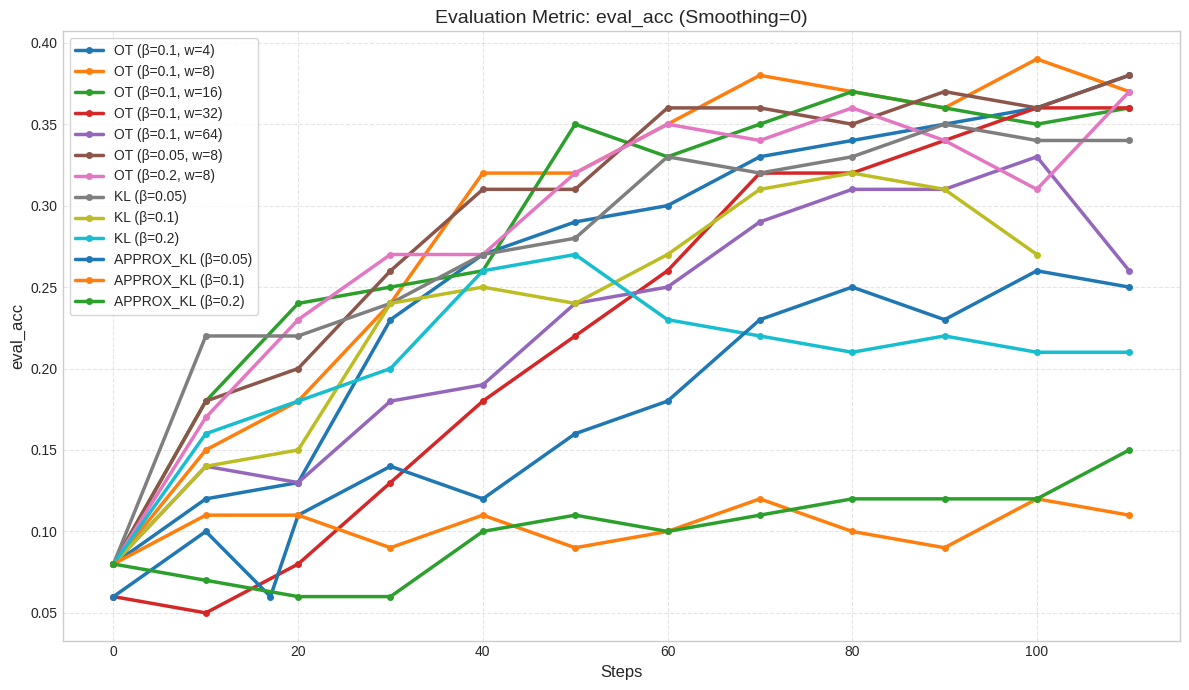

In [5]:
print("Plotting Evaluation Accuracy...")
plot_metrics(df_3b_stable, data_3b, configs, metric='eval_acc', max_steps=110, smoothing=0)

Plotting training accuracy...


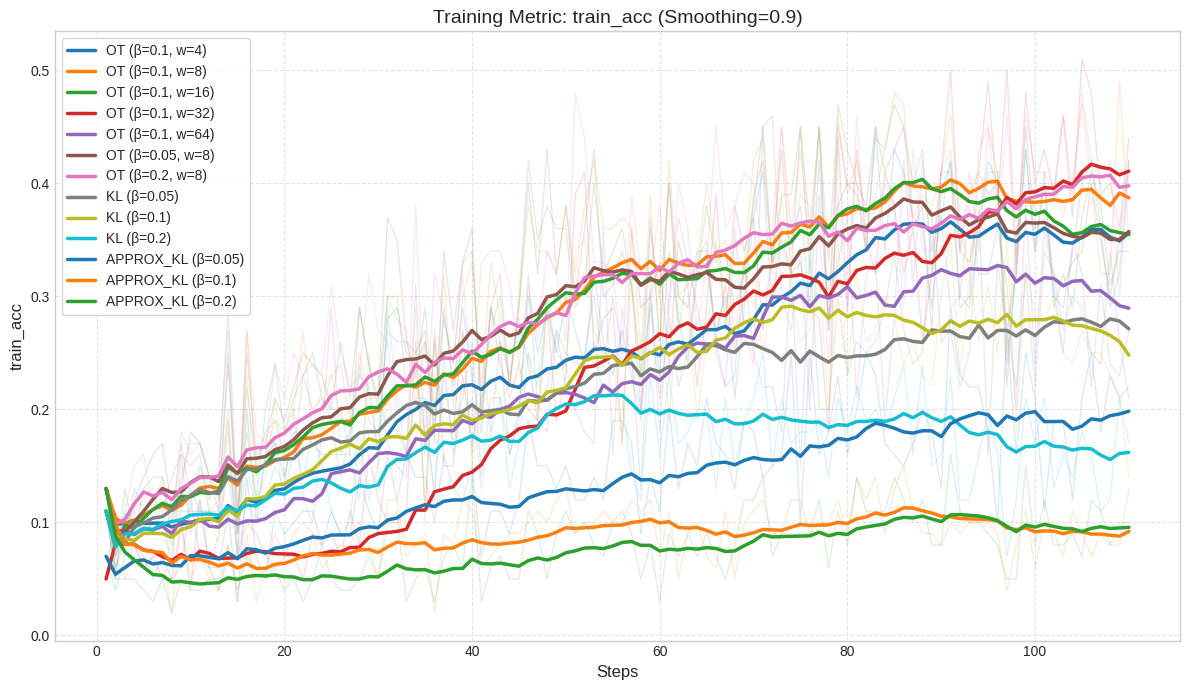

In [6]:
print("Plotting training accuracy...")
plot_metrics(df_3b_stable, data_3b, configs, metric='training accuracy', max_steps=110, smoothing=0.9)

Plotting entropy...


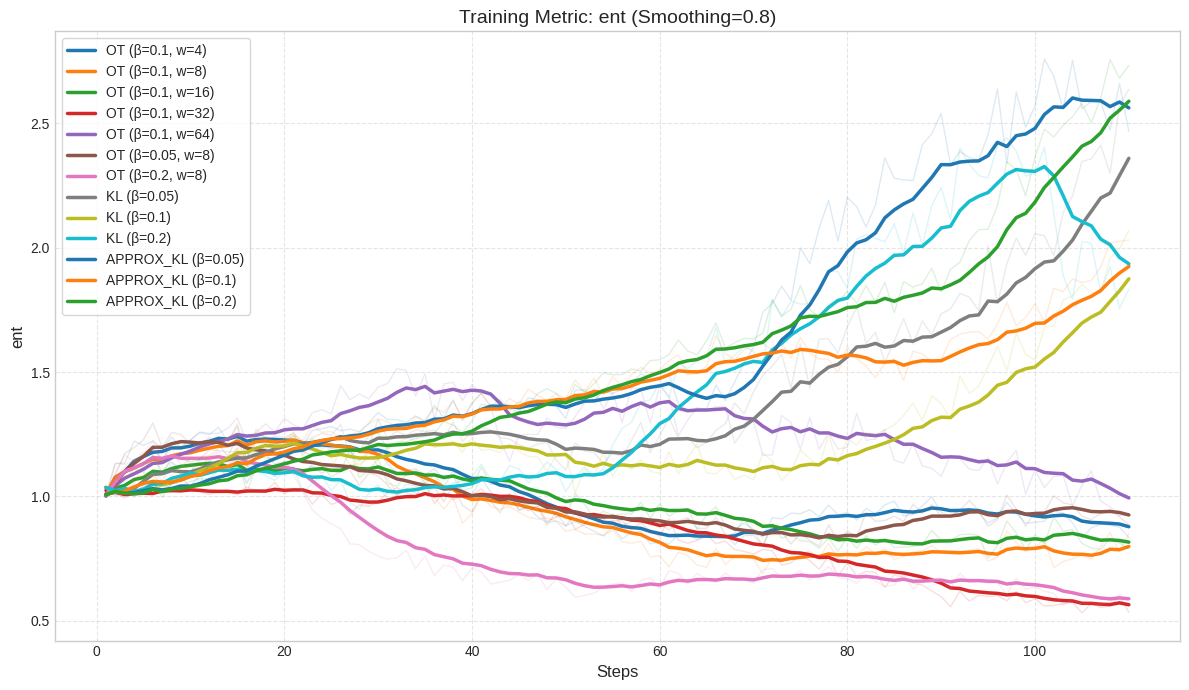

In [7]:
print("Plotting entropy...")
plot_metrics(df_3b_stable, data_3b, configs, metric='entropy', max_steps=110, smoothing=0.8)

Plotting distance...


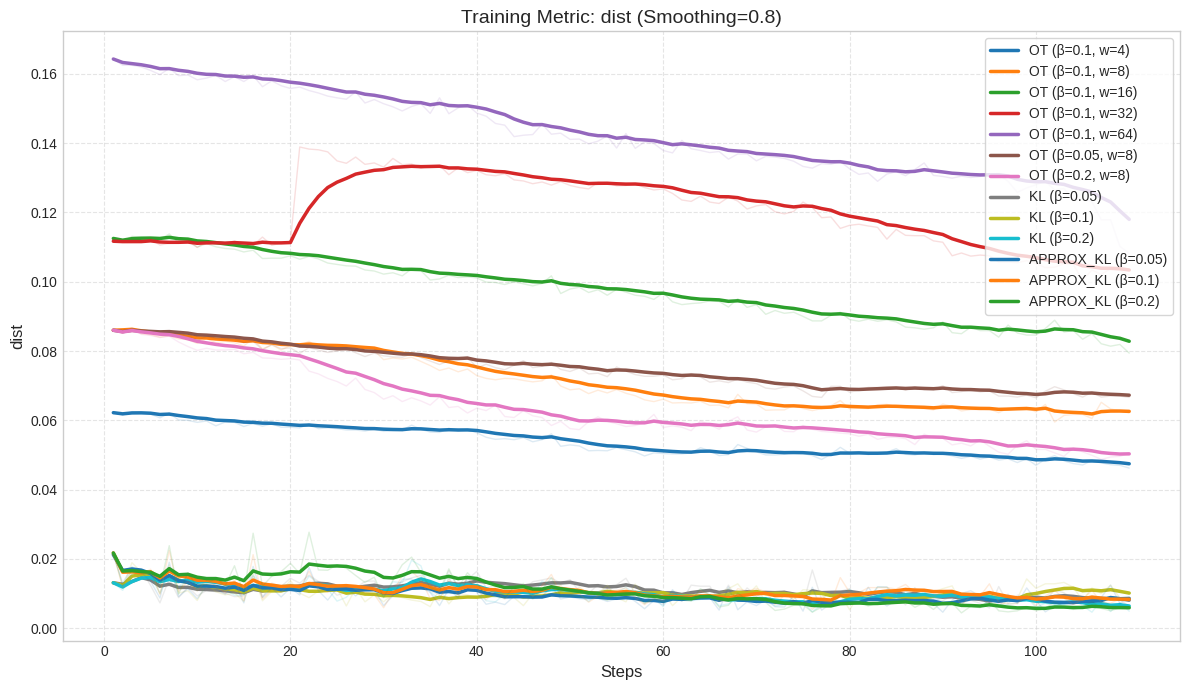

In [8]:
print("Plotting distance...")
plot_metrics(df_3b_stable, data_3b, configs, metric='distance', max_steps=110, smoothing=0.8)


=== Training Speed Analysis ===


,Config,Model,Mean (s/step),Median (s/step),Std Dev,Total Valid Steps
1,"OT (β=0.1, w=16)",3b,99.711111,45.000000,149.424062,135
5,APPROX_KL (β=0.1),3b,84.402516,45.000000,125.053412,159
0,"OT (β=0.1, w=8)",3b,86.128920,47.000000,123.044881,287
3,"OT (β=0.1, w=64)",3b,114.811475,49.000000,303.779153,122
4,KL (β=0.1),3b,127.759259,93.000000,115.644223,108
2,"OT (β=0.1, w=32)",3b,138.125000,103.000000,121.147749,112


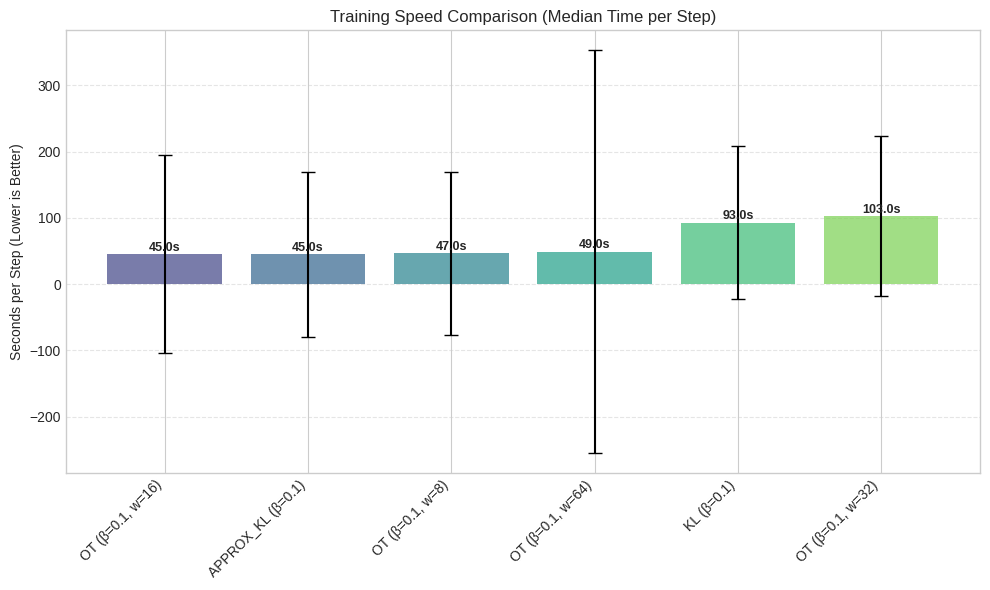

In [9]:
def analyze_training_speed(summary_df, detailed_data, target_configs, plot=True):
    """
    Calculates and plots the training speed (seconds per step).
    
    Args:
        summary_df (pd.DataFrame): Filtered summary table.
        detailed_data (dict): Dictionary containing logs.
        target_configs (list): List of [method, beta, window(opt)].
        plot (bool): Whether to generate a bar chart.
        
    Returns:
        pd.DataFrame: Table of speed statistics.
    """
    speed_stats = []

    for config in target_configs:
        method = config[0]
        beta = config[1]
        target_window = config[2] if len(config) > 2 else None

        mask = (summary_df['method'] == method) & (np.isclose(summary_df['beta'], beta))
        if target_window is not None:
            mask = mask & (summary_df['window'] == target_window)
        else:
            mask = mask & (summary_df['window'].isna())

        matched_experiments = summary_df[mask]

        if matched_experiments.empty:
            continue

        for _, row in matched_experiments.iterrows():
            exp_id = row['exp_id']
            if exp_id not in detailed_data: continue

            df_train = detailed_data[exp_id]['train'].sort_index()
            
            if len(df_train) < 2: continue

            time_deltas = df_train['timestamp'].diff().dt.total_seconds()
            step_deltas = df_train.index.to_series().diff()
            
            raw_speeds = time_deltas / step_deltas.replace(0, np.nan)
            
            valid_speeds = raw_speeds[(raw_speeds < 3600) & (raw_speeds > 0.1)]
            
            if valid_speeds.empty: continue

            if pd.notna(row['window']):
                label = f"{method.upper()} (β={beta}, w={int(row['window'])})"
            else:
                label = f"{method.upper()} (β={beta})"
                
            speed_stats.append({
                "Config": label,
                "Model": row['model'],
                "Mean (s/step)": valid_speeds.mean(),
                "Median (s/step)": valid_speeds.median(),
                "Std Dev": valid_speeds.std(),
                "Total Valid Steps": len(valid_speeds)
            })

    df_speed = pd.DataFrame(speed_stats)
    
    if df_speed.empty:
        print("No valid speed data found.")
        return pd.DataFrame()

    df_speed = df_speed.sort_values("Median (s/step)")

    print("\n=== Training Speed Analysis ===")
    display(df_speed.style.background_gradient(subset=['Mean (s/step)', 'Median (s/step)'], cmap='RdYlGn_r'))

    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.style.use('seaborn-v0_8-whitegrid')

        x_pos = np.arange(len(df_speed))
        bars = plt.bar(
            x_pos, 
            df_speed['Median (s/step)'], 
            yerr=df_speed['Std Dev'], 
            capsize=5, 
            alpha=0.7,
            color=plt.cm.viridis(np.linspace(0.2, 0.8, len(df_speed)))
        )
        
        plt.xticks(x_pos, df_speed['Config'], rotation=45, ha='right')
        plt.ylabel("Seconds per Step (Lower is Better)")
        plt.title("Training Speed Comparison (Median Time per Step)")
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}s',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
            
        plt.tight_layout()
        plt.show()

    return df_speed


configs_to_analyze = [
    ['ot', 0.1, 8],
    ['ot', 0.1, 16],
    ['ot', 0.1, 32],
    ['ot', 0.1, 64],
    ['kl', 0.1],
    ['approx_kl', 0.1]
]

# Run analysis
_ = analyze_training_speed(df_3b_stable, data_3b, configs_to_analyze)

Loading Qwen/Qwen2.5-3B...


Loading checkpoint shards: 100%|██████████| 2/2 [00:51<00:00, 25.71s/it]


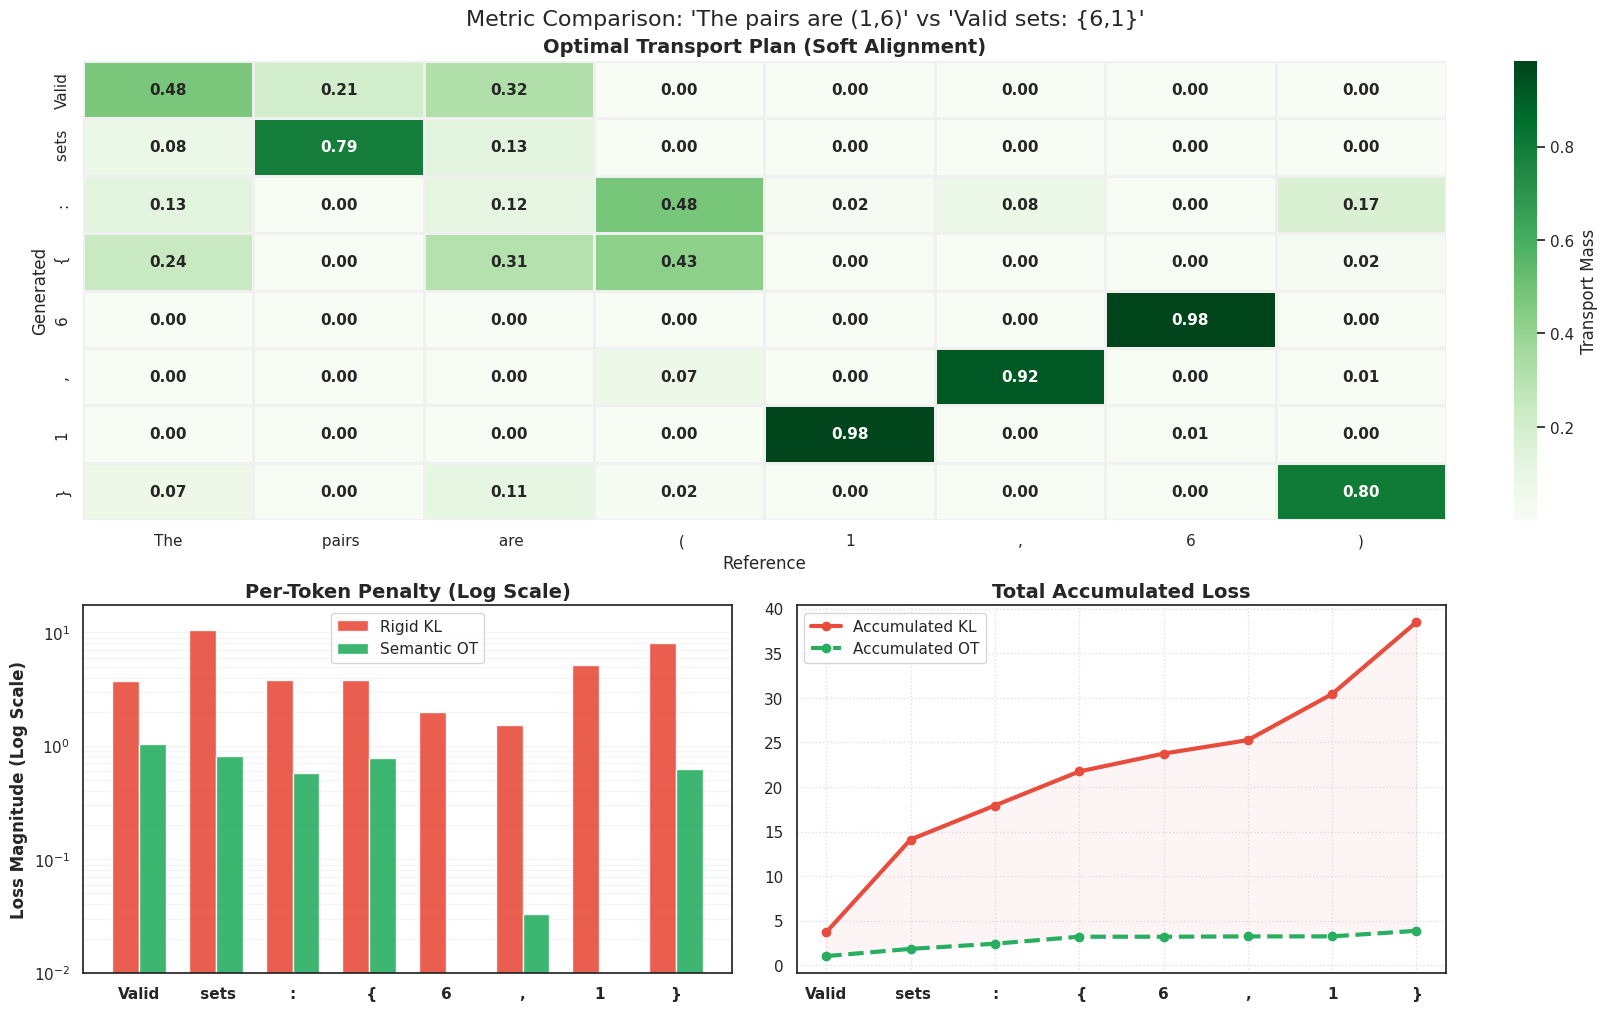

In [36]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "Qwen/Qwen2.5-3B"
print(f"Loading {model_id}...")

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cpu", trust_remote_code=True)
model.eval()

ref_text = "The pairs are (1,6)"
gen_text = "Valid sets: {6,1}"

ref_ids = tokenizer.encode(ref_text, return_tensors='pt')[0]
gen_ids = tokenizer.encode(gen_text, return_tensors='pt')[0]

min_len = min(len(ref_ids), len(gen_ids))
ref_ids = ref_ids[:min_len]
gen_ids = gen_ids[:min_len]

ref_tokens = [tokenizer.decode([t]) for t in ref_ids]
gen_tokens = [tokenizer.decode([t]) for t in gen_ids]


emb_layer = model.get_input_embeddings()
with torch.no_grad():
    emb_ref = F.normalize(emb_layer(ref_ids), p=2, dim=1)
    emb_gen = F.normalize(emb_layer(gen_ids), p=2, dim=1)

    cost_matrix = 1.0 - torch.mm(emb_gen, emb_ref.t())

    def get_transport_plan(cost, eps=0.05):
        log_K = -cost / eps
        u, v = torch.zeros(cost.size(0)), torch.zeros(cost.size(1))
        for _ in range(50):
            u = -torch.logsumexp(log_K + v.unsqueeze(0), 1)
            v = -torch.logsumexp(log_K.t() + u.unsqueeze(0), 1)
        return torch.exp(u.unsqueeze(1) + v.unsqueeze(0) + log_K)

    P_matrix = get_transport_plan(cost_matrix)
    P_np = P_matrix.numpy()
    C_np = cost_matrix.numpy()
    ot_loss_vals = [np.sum(P_np[i] * C_np[i]) for i in range(len(gen_tokens))]

ce_loss_vals = []
curr_input = torch.tensor([[tokenizer.bos_token_id or tokenizer.eos_token_id]])
with torch.no_grad():
    for i in range(len(gen_tokens)):
        outputs = model(curr_input)
        next_token_logits = outputs.logits[0, -1, :]
        target_id = ref_ids[i]
        loss = F.cross_entropy(next_token_logits.unsqueeze(0), target_id.unsqueeze(0))
        ce_loss_vals.append(loss.item())
        next_input = gen_ids[i].unsqueeze(0).unsqueeze(0)
        curr_input = torch.cat([curr_input, next_input], dim=1)

sns.set_theme(style="white", font_scale=1.0)
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.8], figure=fig)

ax_map = fig.add_subplot(gs[0, :])
ax_bars = fig.add_subplot(gs[1, 0])
ax_cum = fig.add_subplot(gs[1, 1])

# Plot 1: Heatmap
annot_kws = {"size": 11, "weight": "bold"}
sns.heatmap(P_np, ax=ax_map, cmap="Greens", annot=True, fmt=".2f",
            xticklabels=ref_tokens, yticklabels=gen_tokens, 
            cbar=True, cbar_kws={"label": "Transport Mass"},
            linewidths=1, linecolor='#f0f0f0', annot_kws=annot_kws)
ax_map.set_title("Optimal Transport Plan (Soft Alignment)", fontweight='bold', fontsize=14)
ax_map.set_xlabel("Reference")
ax_map.set_ylabel("Generated")

x = np.arange(len(gen_tokens))
width = 0.35
color_nll = '#e74c3c'
color_ot = '#27ae60'

bars1 = ax_bars.bar(x - width/2, ce_loss_vals, width, label='Rigid KL', color=color_nll, alpha=0.9, log=True)
bars2 = ax_bars.bar(x + width/2, ot_loss_vals, width, label='Semantic OT', color=color_ot, alpha=0.9, log=True)

ax_bars.set_title("Per-Token Penalty (Log Scale)", fontweight='bold', fontsize=14)
ax_bars.set_ylabel("Loss Magnitude (Log Scale)", fontweight='bold')
ax_bars.set_xticks(x)
ax_bars.set_xticklabels(gen_tokens, fontweight='bold')
ax_bars.legend()

ax_bars.grid(True, which="both", axis="y", linestyle='-', alpha=0.2)
ax_bars.set_ylim(bottom=0.01) 

cum_ce = np.cumsum(ce_loss_vals)
cum_ot = np.cumsum(ot_loss_vals)
ax_cum.plot(x, cum_ce, label='Accumulated KL', color=color_nll, linewidth=3, marker='o')
ax_cum.plot(x, cum_ot, label='Accumulated OT', color=color_ot, linewidth=3, marker='o', linestyle='--')
ax_cum.fill_between(x, cum_ce, cum_ot, color=color_nll, alpha=0.05)
ax_cum.set_title("Total Accumulated Loss", fontweight='bold', fontsize=14)
ax_cum.set_xticks(x)
ax_cum.set_xticklabels(gen_tokens, fontweight='bold')
ax_cum.legend()
ax_cum.grid(True, linestyle=':', alpha=0.6)

plt.suptitle(f"Metric Comparison: '{ref_text}' vs '{gen_text}'", fontsize=16)
plt.savefig("single_axis_ot_viz.png", dpi=300)
plt.show()